IMPORTING ESSENTIAL LIBRARIES

In [1]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import math
import pandas as pd

READING THE FILE

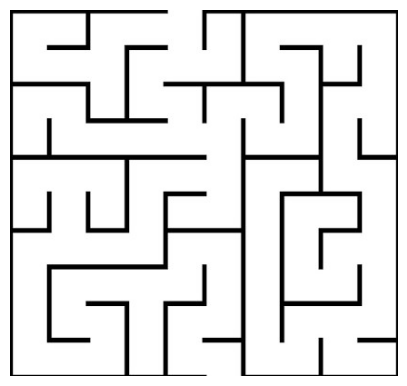

In [2]:
filename = 'Pics and PPTs/genesis_25.png'

# Reading the maze file
img = cv2.imread(filename)  # Put the right path for the maze image
temp = np.copy(img)
plt.figure(figsize=(5,5) )
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

GRAYSCALE CONVERSION

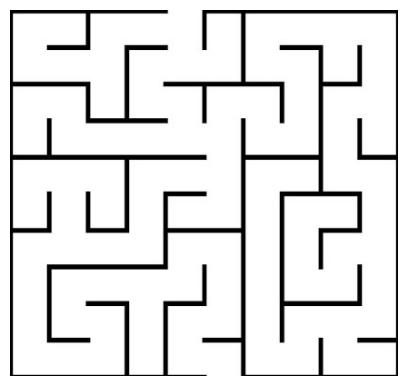

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # converting maze image to grayscale image
plt.figure(figsize=(5,5) )
plt.imshow(gray ,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()

INVERSION AND THRESHOLDING

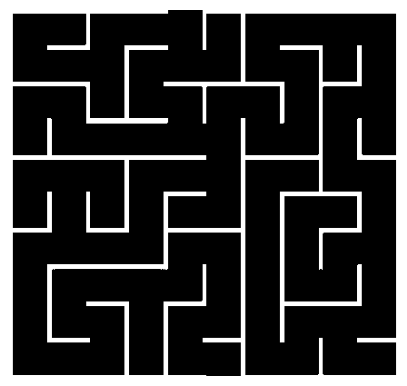

In [4]:
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV) #below 127 goes to white(255)
plt.figure(figsize=(5,5) )
plt.imshow(thresh ,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()

CONTOURING

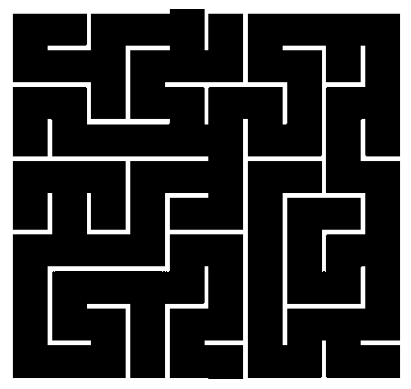

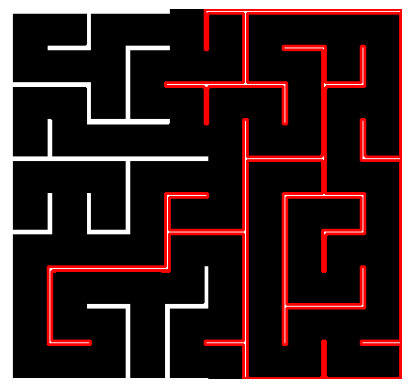

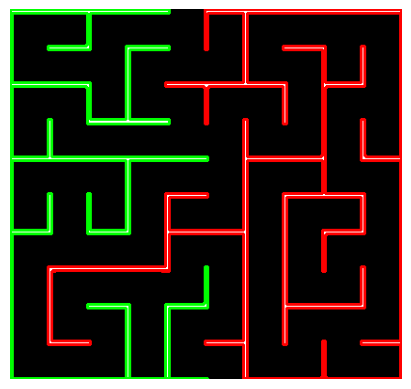

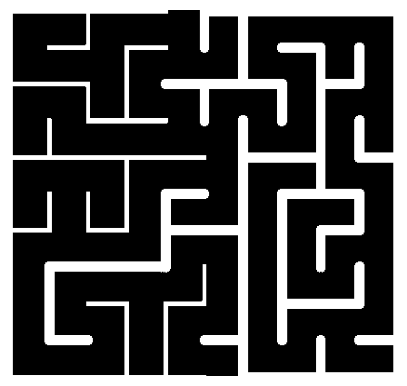

In [5]:
# # # Contours - only binary images, to be detected in white and background in black
# Finding all contours in inverted thresholded image
# cv2.RETR_EXTERNAL: Retrieves only the external contours, or boundaries  of the objects in the image. It does not retrieve contours within contours.

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

width = img.shape[1]
height = img.shape[0]
example1 = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

plt.figure(frameon=False )
plt.imshow(example1)
plt.axis("off")  # Hide axes
plt.show()

example2 = cv2.drawContours(example1, contours, 0, (255, 0 , 0), 2)

plt.figure(frameon=False )
plt.imshow(example2)
plt.axis("off")  # Hide axes
plt.show()
example3 = cv2.drawContours(example2, contours, 1, (0, 255 , 0), 2)

plt.figure(frameon=False )
plt.imshow(example3)
plt.axis("off")  # Hide axes
plt.show()

# draws the first contour in the thresholded image
temp1 = np.copy(thresh)
contours1 = cv2.drawContours(temp1, contours, 0, (255, 255 , 255), 5)
plt.figure(figsize=(5,5) )
plt.imshow(contours1,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()


HIDE THE OTHER LARGER CONTOUR

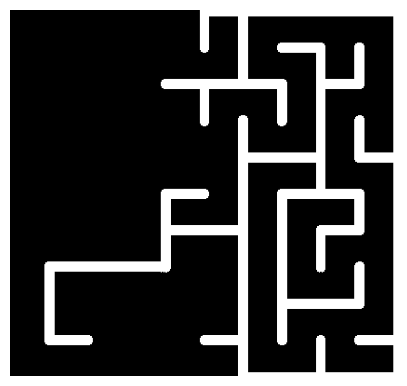

In [6]:
final_contour = cv2.drawContours(contours1, contours, 1, (0, 0, 0), 5)
plt.figure(figsize=(5,5) )
plt.imshow(final_contour,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()

NOISE REMOVAL USING THRESHOLDING

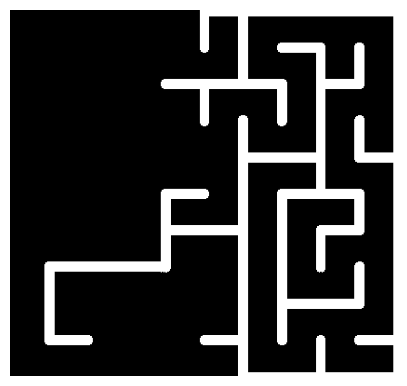

In [7]:
# Threshing it once more just to remove any white noise, we want lines whose white intesnty is really high
ret, thresh = cv2.threshold(final_contour, 240, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(5,5) )
plt.imshow(thresh,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()

 DILATION AND EROSION

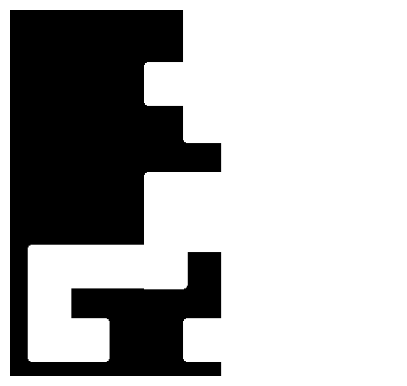

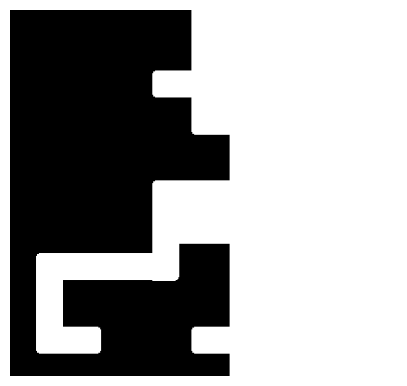

In [8]:
# Determining kernel size for erosion and dilation
# By trial and error (Making sure that the inner spaces are filled while dilating)
ke = 19
kernel = np.ones((ke, ke), np.uint8)

# Dilate
dilation = cv2.dilate(thresh, kernel, iterations=2)
plt.figure(figsize=(5,5) )
plt.imshow(dilation,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()

# Erosion (PS: We are eroding the dilated image)
erosion = cv2.erode(dilation, kernel, iterations=1)
plt.figure(figsize=(5,5) )
plt.imshow(erosion,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()



FIND THE DIFFERENCE BETWEEN TWO IMAGES

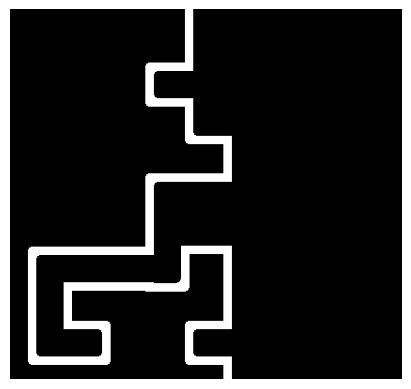

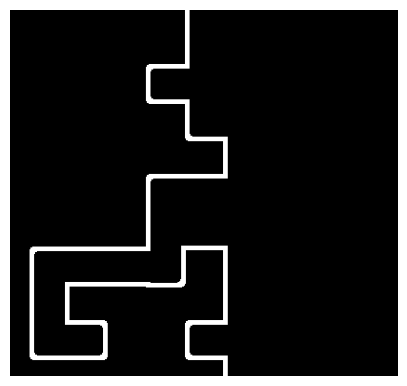

In [9]:
diff = cv2.absdiff(dilation, erosion)
plt.figure(frameon=False )
plt.imshow(diff,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()

# To make the line thinner (We erode the difference again)
kernel1 = np.ones((5, 5), np.uint8)
img_erosion = cv2.erode(diff, kernel1, iterations=1)
plt.figure(figsize=(5,5) )
plt.imshow(img_erosion,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()


SKELETONIZATION

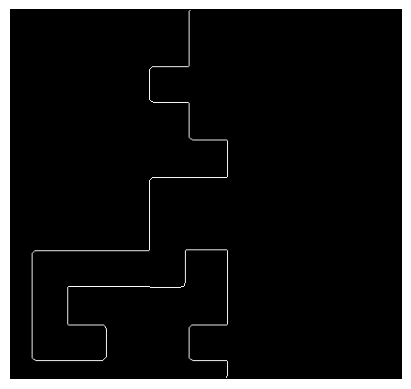

In [10]:
# Skeletonize only works on binary values 0-1, so its necessary to do /255 before
ske = skeletonize(img_erosion / 255)
plt.imshow(ske,cmap='gray')
plt.axis("off")
plt.show()
# inputs Boolean Values, True is 255 (white) and False is 0 (black)
# To get all True
# Skelitonize out indexes from the output of skeletonization

points_arg = []
for i in range(img.shape[0]):  # rows = height (y axis)
    for j in range(img.shape[1]):  # column = width (x axis)
        if ske[i][j] == True:
            points_arg.append((j, i))  # PS : its (j,i)


In [11]:

import matplotlib.animation as animation
from IPython.display import HTML, display

num_points = len(points_arg)
img_copy = img.copy()

# Create frames for the animation
frames = []
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))  # Show initial image (converted to RGB)

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])

# Invert y-axis to match image coordinates
ax.set_ylim(img.shape[0], 0)
ax.set_xlim(0, img.shape[1])

img_frame = img_copy.copy()

# points_arg has (X,y) coordinates
X = []
Y = []

# Create frames where circles appear one by one
for i in range(num_points):
 cv2.circle(img_frame, (points_arg[i][0], points_arg[i][1]), 2, (255, 0, 0), -1)
 img_rgb = cv2.cvtColor(img_frame, cv2.COLOR_BGR2RGB)
 frames.append([ax.imshow(img_rgb, animated=True)])
 X.append(points_arg[i][0])
 Y.append(points_arg[i][1])

# Create the animation
ani = animation.ArtistAnimation(fig, frames, interval=15, blit=True, repeat_delay=1000)

# Convert to HTML5 video and display in Colab
html_animation = ani.to_html5_video()
display(HTML(html_animation))

plt.close(fig)

LOGIC TO GET THE ORDER RIGHT USING DISTANCE

In [12]:
min_arg = np.argmin(np.array(Y))
ord_x = []
ord_y = []

x0 = X[min_arg]
y0 = Y[min_arg]

ord_x.append(x0)
ord_y.append(y0)

distance_list = []
X.pop(0)  # Removes the first element
Y.pop(0)  # Removes the first element

for i in range(len(X)):
    min_dist = 10  # Setting an initial distance
    j_min = 0  # for getting the index
    for j in range(len(X)):
        x1 = X[j]  # first element after removing start element of array
        y1 = Y[j]  # first element after removing start element of array

        dist = (x1 - x0) ** 2 + (y1 - y0) ** 2
        if dist < min_dist:
            min_dist = dist
            x_next = x1
            y_next = y1
            j_min = j

    # Appending the new ordered next element to the ordered list
    ord_x.append(x_next)
    ord_y.append(y_next)

    # Removing the new ordered next element from prev array
    X.pop(j_min)
    Y.pop(j_min)

    # Setting the new ordered element as the new base value x0,y0
    x0 = x_next
    y0 = y_next


ANIMATION OF PROPER PATH

In [13]:
img_copy1 = img.copy()

# Create frames for the animation
frames = []
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))  # Show initial image (converted to RGB)

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])

# Invert y-axis to match image coordinates
ax.set_ylim(img.shape[0], 0)
ax.set_xlim(0, img.shape[1])

img_frame1 = img_copy1.copy()
# Create frames where circles appear one by one
for i in range(num_points):
 cv2.circle(img_frame1, (ord_x[i], ord_y[i]) , 2, (255, 0, 0), -1)
 img_rgb1 = cv2.cvtColor(img_frame1, cv2.COLOR_BGR2RGB)
 frames.append([ax.imshow(img_rgb1, animated=True)])

# Create the animation
ani = animation.ArtistAnimation(fig, frames, interval=15, blit=True, repeat_delay=1000)

# Convert to HTML5 video and display in Colab
html_animation = ani.to_html5_video()
display(HTML(html_animation))

plt.close(fig)

CONVERTING TO ROBOT'S FRAME OF REFERENCE

417
394


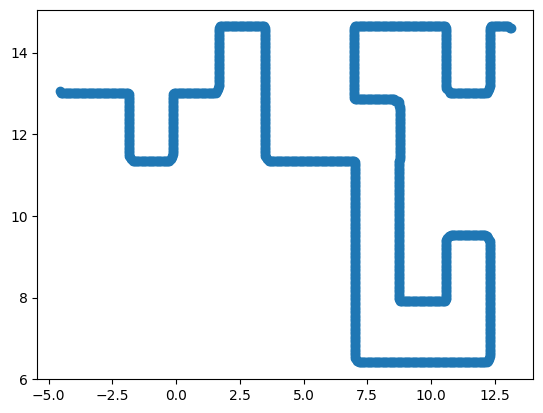

In [14]:
l_x = 15  # Actual width of maze (x-axis)
ip_x = img.shape[1]  # Columns = width (x-axis)
print(ip_x)
l_y = 16.2  # Actual height of maze  (y-axis)
ip_y = img.shape[0]  # Rows = height (y-axis)
print(ip_y)
l_5 = 7  # in cms
servo_to_centre = 13  # in cms

# Setting the scaling factor
c_x = l_x / ip_x
c_y = l_y / ip_y

# Setting the transformation matrix

t_r = [[0, c_y*1.1, (l_5 / 2 - (c_y * ip_y / 2))],
       [c_x*1.1, 0, (servo_to_centre - (c_x * ip_x / 2))]]

points_x = []
points_y = []

for i in range(len(ord_x)):
    points_x.append(ord_x[i])
    points_y.append(ord_y[i])

img_x = []
img_y = []

# Vertical stacking of x and y
p = np.vstack((points_x, points_y, np.ones((1, len(points_x)))))

# Dot product
mat = np.dot(t_r, p)

x = mat[0]
y = mat[1]

# for i in range(len(x)):
#     print(x[i], y[i])

plt.scatter(x, y)
plt.show()


SMOOTHENING

In [15]:
size_x = len(x)

short_x, short_y = [], []

short_x.append(x[0])
short_y.append(y[0])

for i in range(size_x-1):
    if (x[i+1] == x[i] or y[i+1] == y[i]):
        continue
    elif x[i - 1] == x[i]:
        short_x.append(x[i])
        short_y.append(y[i+1])
    elif y[i - 1] == y[i] :
        short_x.append(x[i+1])
        short_y.append(y[i])

short_x.append(x[size_x-1])
short_y.append(y[size_x-1])

smooth_x, smooth_y = [], []

short_size = len(short_x)

for i in range(short_size):
    smooth_x.append(short_x[i])
    smooth_y.append(short_y[i])
    if i < short_size-1:
        smooth_x.append((short_x[i] + short_x[i+1]) / 2)
        smooth_y.append((short_y[i] + short_y[i+1]) / 2)

short_x, short_y = [], []

smooth_size = len(smooth_x)

for i in range(smooth_size):
    short_x.append(smooth_x[i])
    short_y.append(smooth_y[i])
    if i < short_size-1:
        short_x.append((smooth_x[i] + smooth_x[i+1]) / 2)
        short_y.append((smooth_y[i] + smooth_y[i+1]) / 2)

smooth_x, smooth_y = [], []

short_size = len(short_x)

for i in range(short_size):
    smooth_x.append(short_x[i])
    smooth_y.append(short_y[i])
    if i < short_size-1:
        smooth_x.append((short_x[i] + short_x[i+1]) / 2)
        smooth_y.append((short_y[i] + short_y[i+1]) / 2)

short_x, short_y = [], []

smooth_size = len(smooth_x)

for i in range(smooth_size):
    short_x.append(smooth_x[i])
    short_y.append(smooth_y[i])
    if i < short_size-1:
        short_x.append((smooth_x[i] + smooth_x[i+1]) / 2)
        short_y.append((smooth_y[i] + smooth_y[i+1]) / 2)

final_x = short_x
final_y = short_y


for i in range(len(final_x)):
        print(final_x[i], final_y[i])

-4.554771573604061 13.057553956834532
-4.38516497461929 13.055080935251798
-4.215558375634518 13.052607913669064
-4.045951776649746 13.05013489208633
-3.8763451776649744 13.047661870503596
-3.706738578680203 13.045188848920862
-3.537131979695431 13.042715827338128
-3.3675253807106595 13.040242805755394
-3.197918781725888 13.037769784172662
-3.0283121827411166 13.03529676258993
-2.858705583756345 13.032823741007196
-2.689098984771573 13.030350719424462
-2.5194923857868017 13.027877697841728
-2.34988578680203 13.025404676258994
-2.1802791878172583 13.02293165467626
-2.010672588832487 13.020458633093526
-1.8410659898477153 13.017985611510792
-1.8410659898477153 12.91906474820144
-1.8410659898477153 12.820143884892087
-1.8410659898477153 12.721223021582734
-1.8410659898477153 12.622302158273381
-1.8410659898477153 12.523381294964029
-1.8410659898477153 12.424460431654676
-1.8410659898477153 12.325539568345324
-1.8410659898477153 12.226618705035971
-1.8410659898477153 12.127697841726619
-1.

INVERSE KINEMATICS

In [16]:
la = 14  # length of arm A in cm
lb = 20  # length of arm B in cm
lc = 6.9  # distance between
N_Points = len(final_x)

theta_1 = []
theta_4 = []
for i in range(0, N_Points):
    xp = final_x[i]
    yp = final_y[i]

    E1 = -2 * la * xp
    E4 = 2 * la * (-xp + lc)

    F1 = -2 * la * yp
    F4 = -2 * la * yp

    G1 = la ** 2 - lb ** 2 + xp ** 2 + yp ** 2
    G4 = lc ** 2 + la ** 2 - lb ** 2 + xp ** 2 + yp ** 2 - 2 * lc * xp
    # print(i, x[i] , y[i], N_Points)
    temp1 = math.sqrt(E1 ** 2 + F1 ** 2 - G1 ** 2)
    temp4 = math.sqrt(E4 ** 2 + F4 ** 2 - G4 ** 2)

    m1 = G1 - E1
    m4 = G4 - E4
    #
    theta1_pos = 2 * math.atan((-F1 + temp1) / m1)
    theta1_neg = 2 * math.atan((-F1 - temp1) / m1)

    theta4_pos = 2 * math.atan((-F4 + temp4) / m4)
    theta4_neg = 2 * math.atan((-F4 - temp4) / m4)

    theta1_pos = math.degrees(theta1_pos)
    theta1_neg = math.degrees(theta1_neg)
    theta4_pos = math.degrees(theta4_pos)
    theta4_neg = math.degrees(theta4_neg)

    theta_1.append(theta1_pos)
    theta_4.append(theta4_neg)


theta_1_new = []
theta_4_new = []

for i in range(0, N_Points):
    if theta_1[i] < 0:
        temp = 1 * (theta_1[i] + 270)

    if theta_1[i] > 0:
        temp = theta_1[i] - 90

    theta_1_new.append(temp)
    theta_4_new.append(theta_4[i] + 90)


DOWNLOADING THE ANGLES

In [17]:
import pandas as pd

# Create a dictionary with the lists
data = {'THETA 1': theta_1_new, 'THETA 4': theta_4_new}

# Create a Pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Create a CSV file from the DataFrame
csv_filename = 'angles.csv' # Choose a filename for your CSV file
df.to_csv(csv_filename, index=False)  # index=False to avoid writing row indices to the CSV

print(f"Successfully downloaded {csv_filename}")

Successfully downloaded angles.csv
